In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install rarfile


In [4]:
import rarfile

# Path to the RAR file on Google Drive
rar_file_path = '/content/drive/MyDrive/PlantVillage.rar'

# Path to the directory where you want to extract the files
extract_dir_path = '/content/Plant_Uncompressed/'

# Extract the RAR file
with rarfile.RarFile(rar_file_path, 'r') as rar_ref:
    rar_ref.extractall(extract_dir_path)

print("Extraction complete.")


Extraction complete.


In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 60

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Plant_Uncompressed/PlantVillage",
    shuffle= True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE



)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
len(dataset)

68

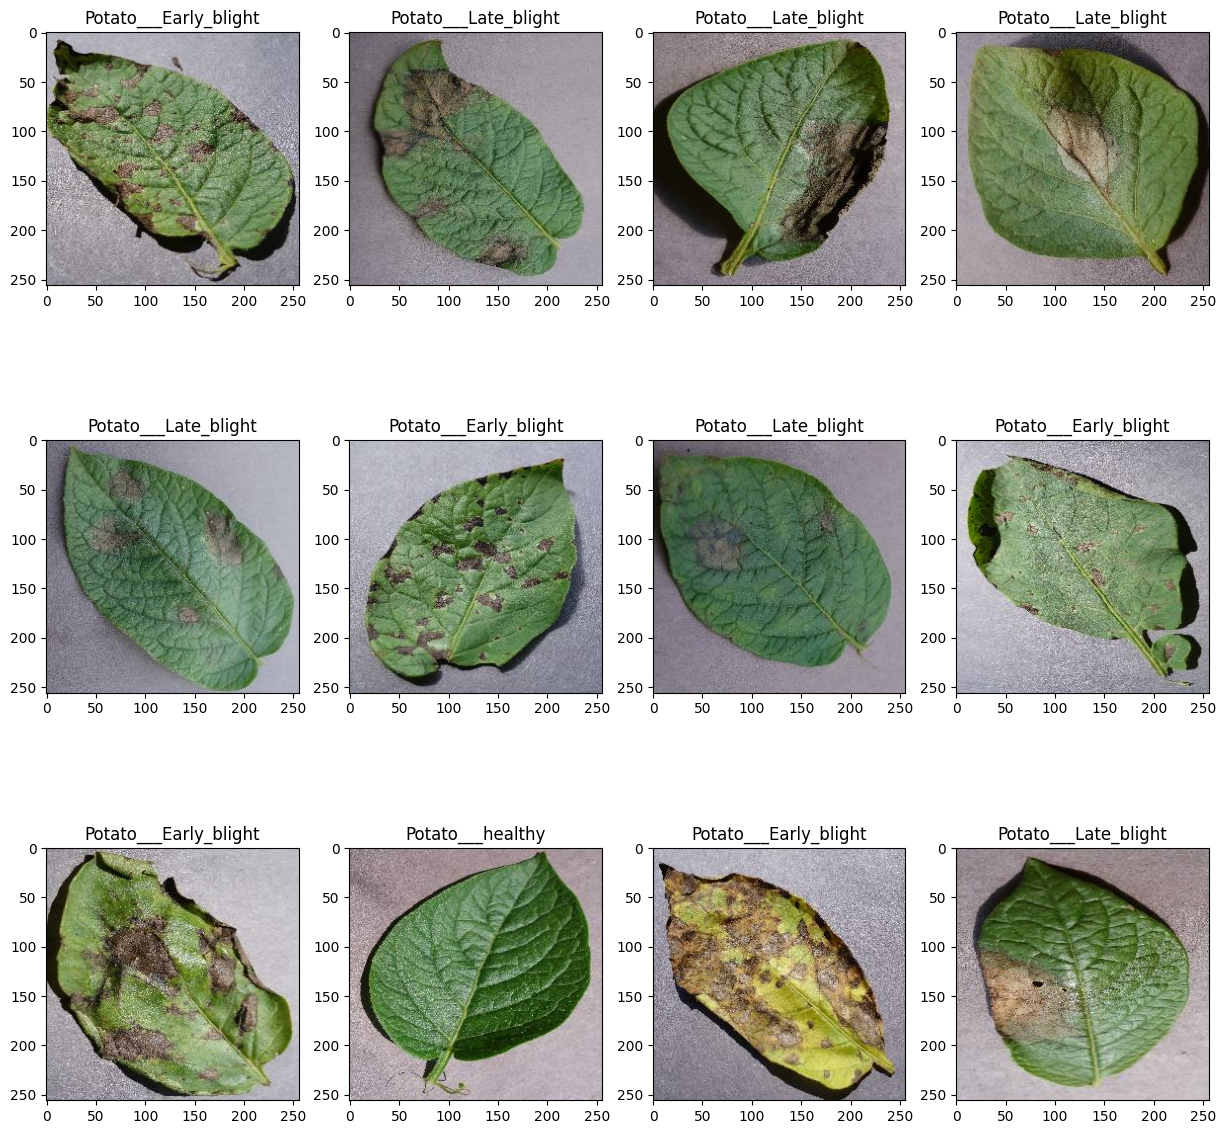

In [9]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range (12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
    #   plt.axis("off")
    #     print(image_batch)
    #     print(label_batch.numpy())

In [10]:
# 80% => training
# 20% => 10% Validation, 10% Test

In [11]:
train_size = 0.8
len (dataset)* train_size


54.400000000000006

In [12]:
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [14]:
val_size = 0.1
len (dataset)*val_size


6.800000000000001

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [17]:
# We know make a function which will do all the obove step by using nice python scripts

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size= int(train_split * ds_size)
    val_size = int (val_split * ds_size)

    train_ds = ds.take (train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [21]:
len(test_ds)

8

In [22]:
len(val_ds)

6

In [23]:
#It will improve the model performance by consuming less time than usual by prefetch and cache methods

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [25]:
#LAYERS OF PREPROCESSING

In [26]:
#Usually the numpy file is between 0-255 but we want it to be in the range of 0-1
#Along with that we want to make sure that our dataset only consists of 256*256 images so to do that we will use resizing code

In [27]:
resize_and_rescale =  tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [28]:
#We also used data augmentation as it will help to make our model more robust and it also increases our dataset which helps model to make it more precise

In [29]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
   # layers.experimental.preprocessing.RandomZoom(0.2, height_factor=(-0.2, 0.2)),  # Zoom images randomly
    layers.experimental.preprocessing.RandomContrast(0.1),  # Adjust contrast randomly
])


In [30]:
# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,  # Stop training if validation loss doesn't improve for 10 epochs
    restore_best_weights=True  # Restore weights from the best epoch
)


In [31]:
#Model Training (Network Architecture)

In [32]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),  # Example dropout rate of 50%
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [34]:
#Model Compile

In [35]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [36]:
#Model training

In [37]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds

)

Epoch 1/60
54/54 [==============================] - 20s 124ms/step - loss: 0.9081 - accuracy: 0.5133 - val_loss: 0.8468 - val_accuracy: 0.5677
Epoch 2/60
54/54 [==============================] - 3s 61ms/step - loss: 0.6668 - accuracy: 0.6997 - val_loss: 0.5216 - val_accuracy: 0.7760
Epoch 3/60
54/54 [==============================] - 3s 61ms/step - loss: 0.5095 - accuracy: 0.7691 - val_loss: 0.3035 - val_accuracy: 0.8958
Epoch 4/60
54/54 [==============================] - 3s 63ms/step - loss: 0.3637 - accuracy: 0.8495 - val_loss: 1.1029 - val_accuracy: 0.6875
Epoch 5/60
54/54 [==============================] - 3s 60ms/step - loss: 0.4258 - accuracy: 0.8345 - val_loss: 0.3178 - val_accuracy: 0.8646
Epoch 6/60
54/54 [==============================] - 3s 60ms/step - loss: 0.3084 - accuracy: 0.8796 - val_loss: 0.2202 - val_accuracy: 0.9219
Epoch 7/60
54/54 [==============================] - 4s 80ms/step - loss: 0.2516 - accuracy: 0.8981 - val_loss: 0.1815 - val_accuracy: 0.9375
Epoch 8/60


In [38]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 28ms/step - loss: 0.0185 - accuracy: 0.9883


In [39]:
#Evaluating Metrices

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [41]:
#Plotting Graphs

Text(0.5, 1.0, 'Training and Validation Accuracy')

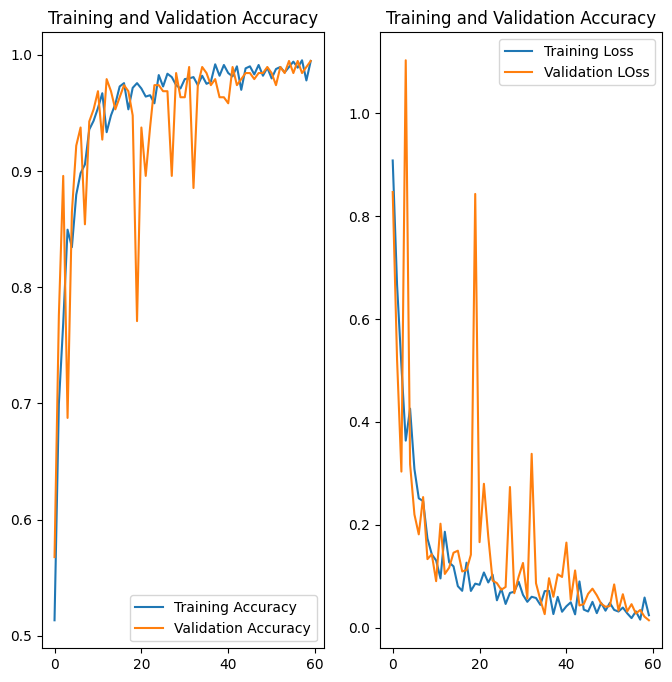

In [42]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title ("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation LOss")
plt.legend(loc='upper right')
plt.title ("Training and Validation Accuracy")

In [43]:
#Prediction

First image to predict
actual label Potato___Early_blight
1/1 [==============================] - 0s 152ms/step
predicted label: Potato___Early_blight


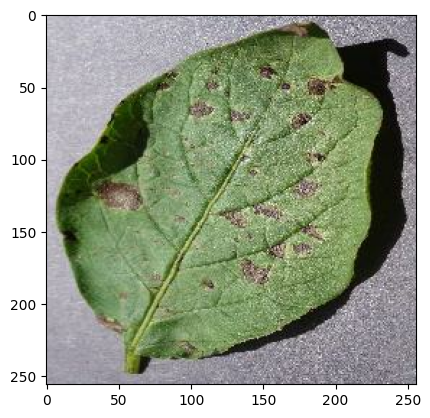

In [44]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("First image to predict")
  plt.imshow(first_image)
  print("actual label", class_names [first_label])

  batch_prediction = model.predict(image_batch)
  print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [45]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) # Create Batch

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round (100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


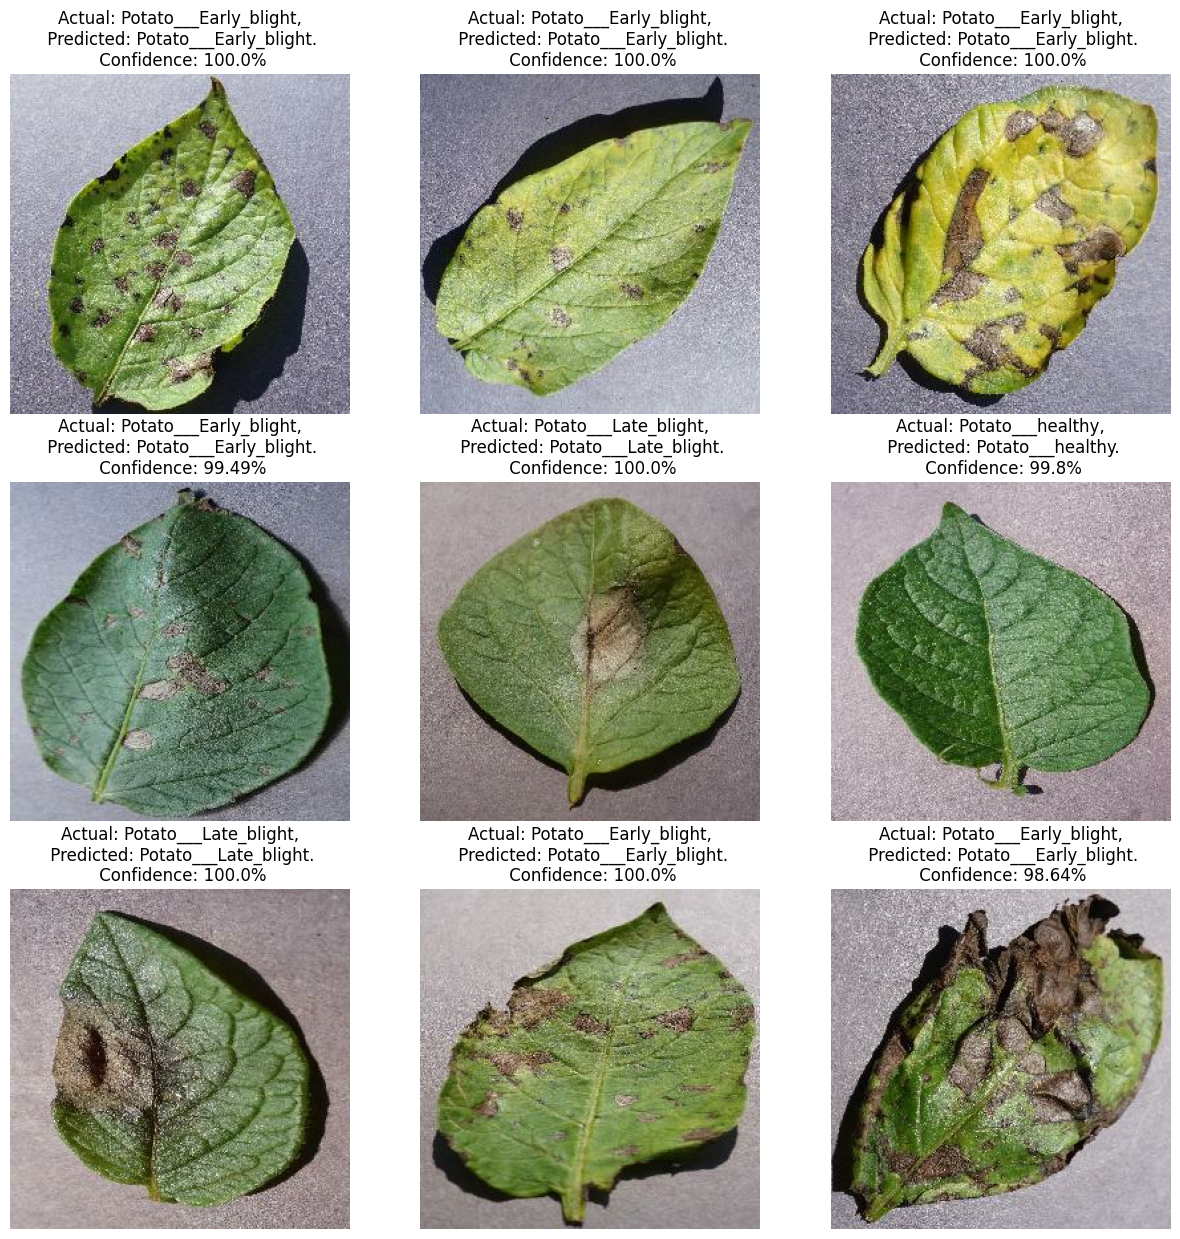

In [49]:
plt.figure(figsize= (15,15))
for images, labels in test_ds.take(1):
  for i in range (9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

    plt.axis("Off")

In [50]:
import os
model_version = max([int(i) for i in os.listdir("/content/Models/")+[0]])+1
model.save(f"/content/Models/{model_version}")

In [53]:
model.save('model1.keras')  # Replace 'my_model.keras' with your desired filename


In [54]:
model.save('/content/Model Python')  # Replace 'saved_model/my_model' with your desired directory


In [55]:
import pickle
import tensorflow.keras.models as keras_models


In [56]:
# Ensure your model is already defined and trained
with open('saved_model.pkl', 'wb') as f:  # Replace 'saved_model.pkl' with your desired filename
    pickle.dump(model, f)


In [57]:
model.save('my_model.h5')  # Replace 'my_model.h5' with your desired filename


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
